<a href="https://colab.research.google.com/github/MatteoBenati/Tesi/blob/main/DreamingDistributions2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
import torch
import torch.nn as nn
import copy
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import math
import os
from random import sample
import pandas as pd
import sys
import timeit
import pickle
from collections.abc import Iterable
#from DreamingLearningClass import DreamingLearningClass

import scipy
from scipy.stats import gaussian_kde
from scipy.stats import linregress
from scipy import stats
from scipy.special import rel_entr
from scipy.optimize import curve_fit
from scipy.spatial import distance

In [79]:
def ma(x, wlen):
    mean = []
    std = []
    
    tlist = []
    
    sumt = 0
    for k, el in enumerate(x):
        if len(tlist) < wlen:
            tlist.append(el)
            sumt += el
        else:
            el_out = tlist.pop(0)
            tlist.append(el)
            sumt += el - el_out
        mean.append(sumt / len(tlist))
        
        tstd = 0
        for j, ss in enumerate(tlist):
            tstd += (ss - mean[-1]) ** 2
        std.append(np.sqrt(tstd / len(tlist)))
        
    return np.array(mean), np.array(std)


def ma_np(x, wlen):
    mean = []
    std = []

    tlist = []

    for k, el in enumerate(x):
        if len(tlist) < wlen:
            tlist.append(el)
        else:
            el_out = tlist.pop(0)
            tlist.append(el)

        mean.append(np.array(tlist).mean())
        std.append((np.array(tlist) - mean[-1]).std())

    return np.array(mean), np.array(std)

### Making a distributions

In [80]:
n_bins = 200

Definizione di Entropia + Esempio

In [81]:
def entropy(distr, norm=True):
    distr = np.array(distr)
    min_bin_value = 1.e-12
    ind = np.where(distr > min_bin_value)[0]
    if norm:
        return (-distr[ind] * np.log(distr[ind])).sum() / np.log(distr.shape[0])
    else:
        return (-distr[ind] * np.log(distr[ind])).sum()

Entropia_esempio_1=(0.01,0.97,0.01,0.01,0.0)
Entropia_esempio_2=(0.24,0.24,0.24,0.28,0.0)
print(entropy(Entropia_esempio_1,norm=False))
print(entropy(Entropia_esempio_1,norm=True))
print(entropy(Entropia_esempio_2,norm=False))
print(entropy(Entropia_esempio_2,norm=True))

0.16770053683981007
0.10419820208297516
1.3839541652885137
0.8598990707230408


**Divergenza di Kullback-Leiber**

In [82]:
def kl_divergence(distr1, distr2):
    distr1 = np.array(distr1)
    distr2 = np.array(distr2)
    return (distr1 * np.log2(distr1 / distr2)).sum()

print(kl_divergence(Entropia_esempio_1,Entropia_esempio_2))

nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


**Definizione distanza euclidea**

In [83]:
def euc_distance(distr1, distr2):
    distr1 = np.array(distr1)
    distr2 = np.array(distr2)
    return (pow((distr1*distr1 - distr2*distr2).sum(),0.5)+0.001)

print(euc_distance((0.67,0.33,0.0,0.0,0.0),(0.67,0.33,0.0,0.0,0.0)))

0.001


**Definizione della distanza di Kantorovich (Earth Mover's Distance)**

In [84]:
def emd(distr1, distr2):
    distr1 = np.array(distr1)
    distr2 = np.array(distr2)
    return scipy.stats.wasserstein_distance(distr1,distr2)

print(emd(Entropia_esempio_1,Entropia_esempio_2))

0.27599999999999997


SoftMax

In [85]:
def softmax(x, temperature):
    if temperature > 0.0:
        return np.exp(x/temperature) / np.exp(x/temperature).sum()
    else:
        ind = np.argmax(x)
        distr = np.zeros_like(x)
        distr[ind] = 1.0
        return distr

**Trova Distribuzione a Entropia scelta**

In [86]:
def find_distribution(x, target_entropy, max_diff = 1e-10):
    temperature = 1
    distr = softmax(x, temperature)
    entr = entropy(distr)

    temp_step = 0.1

    if entr > target_entropy: direction = -1
    else: direction = 1


    while np.abs(entr - target_entropy) > max_diff:
        if direction == -1: temperature -= temp_step
        else: temperature += temp_step

        distr = softmax(x, temperature)
        entr = entropy(distr)

        if entr > target_entropy:
            if direction == 1:
                temp_step /= 2
                direction = -1
            else:
                direction = -1
        else:
            if direction == -1:
                temp_step /= 2
                direction = 1
            else:
                direction = 1
    return distr

0.700182381288774
0.6996244618663312


<BarContainer object of 200 artists>

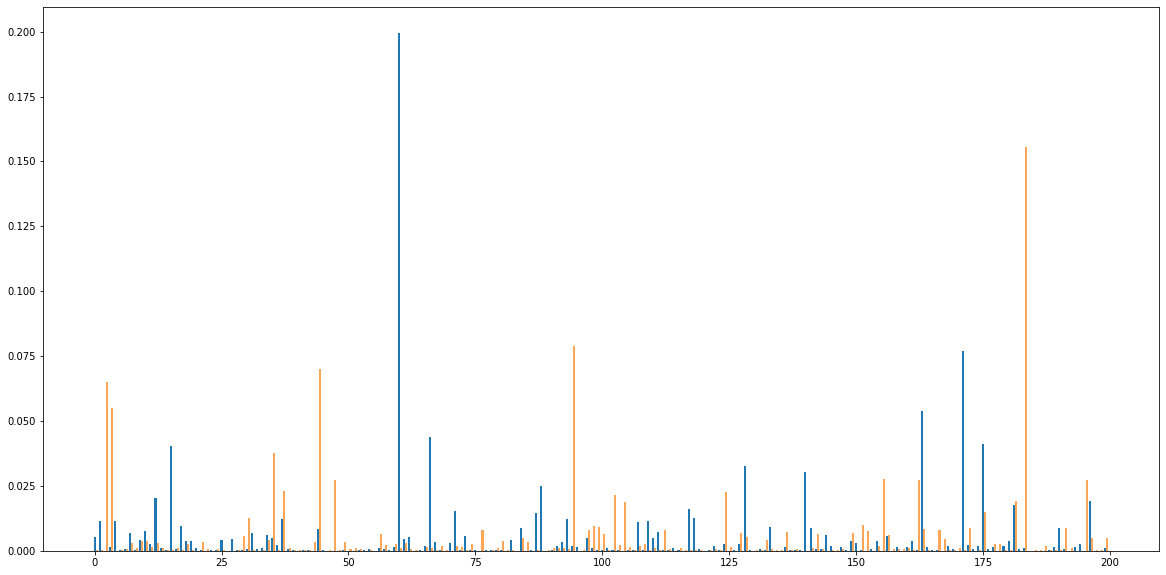

In [113]:
mu = 0
std = 1

x = np.random.randn(n_bins) * std + mu
y = np.random.randn(n_bins) * std + mu
distr_norm_entropy = 0.7
distr1 = find_distribution(x, distr_norm_entropy, max_diff=1e-3)
distr2 = find_distribution(y, distr_norm_entropy, max_diff=1e-3)

print(entropy(distr1, norm=True))
print(entropy(distr2, norm=True))

width=0.4
plt.bar(np.arange(len(distr1)), distr1, width=width)
plt.bar(np.arange(len(distr2))+width, distr2, alpha=0.7, width=width)
#plt.yscale('log')

#### Generating a non-stationary sequence

Sequenza Gradino

In [114]:
def get_non_stationary_sequence(initial_entropy, final_entropy):
    subseqs_len = 50000
    transitions_len = 100
    n_subseqs = 2
    x = np.random.randn(n_bins) * std + mu
    distr0 = find_distribution(x, initial_entropy, max_diff=1e-5)
    
    
    if type(subseqs_len) == int:
        subseqs_len = [subseqs_len] * n_subseqs
    else:
        n_subseqs = len(subseqs_len)
    if type(transitions_len) == int:
        transitions_len = [transitions_len] * (n_subseqs - 1)

    distrs = [distr0]
    for k in range(1, len(subseqs_len)):
        distr_t = distrs[-1].copy()
        y = np.random.randn(n_bins) * std + mu 
        #se voglio avere che le distribuzioni iniziali e finali sono qualitativamente diverse e non solo più o meno schiacciate metto y al posto di x in find_distributions
        distrs.append(find_distribution(y, final_entropy, max_diff=1e-5))

    def lin_distrs(distr0, distr1, k, n_steps):
        dd = (distr1 - distr0) * k / n_steps + distr0
        return dd

    seq = []
    entropy_seq = []
    distrs_seq = []
    for k in range(len(subseqs_len)):
        seqt = np.random.choice(range(n_bins), size=subseqs_len[k], replace=True, p=distrs[k])
        seq += list(seqt)
        entropy_seq += [entropy(distrs[k], norm=False)] * subseqs_len[k]
        for j in range(subseqs_len[k]):
            distrs_seq.append(distrs[k])

        # Transition
        if k < len(subseqs_len) -1:
            for t in range(transitions_len[k]):
                distrt = lin_distrs(distrs[k], distrs[k+1], t, transitions_len[k])
                seq.append(np.random.choice(range(n_bins), size=1, replace=True, p=distrt)[0])
                entropy_seq.append(entropy(distrt, norm=False))
                distrs_seq.append(distrt)
                
    non_stationary_dict = dict()
    non_stationary_dict['seq'] = seq
    non_stationary_dict['distrs'] = distrs
    non_stationary_dict['entropy_seq'] = entropy_seq
    non_stationary_dict['distrs_seq'] = distrs_seq
    non_stationary_dict['subseqs_len'] = subseqs_len
    non_stationary_dict['transitions_len'] = transitions_len
                
    return non_stationary_dict

#### Configurazione rete


In [115]:
class FeedForward(torch.nn.Module):
    def __init__(self, config):
        super(FeedForward, self).__init__()
        self.input_size = config['network']['input_size']
        self.output_size = config['network']['output_size']
        self.hidden_size = config['network']['hidden_size']
        self.hidden_activation = config['network']['hidden_activation']
        self.n_layers = config['network']['n_layers']
        self.learning_rate = config['train']['learning_rate']
        self.dropout = config['train']['dropout']

        if isinstance(self.hidden_size, Iterable) == False:
            self.hidden_size = [self.hidden_size] * self.n_layers
        
        if type(self.hidden_activation) == str:
            self.hidden_activation = [self.hidden_activation] * self.n_layers

        if len(self.hidden_size) != len(self.hidden_activation):
            raise ValueError(f'Wrong hiddden parameters! hidden size:{len(self.hidden_size)}, hidden activation:{len(self.hidden_activation)}')

        self.n_layers = len(self.hidden_size)

        # NN Architecture
        self.embedding = torch.nn.Embedding(self.input_size, self.hidden_size[0])

        for k in range(len(self.hidden_activation)):
            if self.hidden_activation[k].lower() == 'tanh':
                self.hidden_activation[k] = torch.nn.Tanh()
            elif self.hidden_activation[k].lower() == 'sigmoid':
                self.hidden_activation[k] = torch.nn.Sigmoid()
            elif self.hidden_activation[k].lower() == 'relu':
                self.hidden_activation[k] = torch.nn.ReLU()
            else:
                raise ValueError(f'Wrong hiddden activation:{self.hidden_activation[k]}')

        self.linear_list = torch.nn.ModuleList()
        for k in range(self.n_layers - 1):
            self.linear_list.append(torch.nn.Linear(self.hidden_size[k], self.hidden_size[k+1]))

        self.decoder = torch.nn.Linear(self.hidden_size[-1], self.output_size)

    def forward(self, inp):
        batch_size = inp.size(1)
        seq_len = inp.size(0)
        output = self.embedding(inp)

        for k in range(self.n_layers - 1):
            output = self.hidden_activation[k](output)
            output = self.linear_list[k](output)

        output = self.hidden_activation[-1](output)
        output = self.decoder(output)
        m = torch.nn.Softmax(dim=2)
        #distribution = m(output.detach().cpu().flatten()).numpy()
        distribution = m(output)
        return output, distribution

    def sample(self, inp, seq_length, temperature, device):
        m = torch.nn.Softmax(dim=0)
        batch_size = inp.size(1)
        inp = inp.to(device)
        #hidden_sample = (hidden[0].clone().to(device), hidden[1].clone().to(device))

        with torch.no_grad():
            self.eval()
            sample = torch.zeros((seq_length+1, batch_size), dtype=torch.long)
            sample[0, :] = inp[-1, :]
            
            if inp.size(0) > 1:
                _0, _1 = self.forward(inp[:-1])
            else:
                _0, _1 = self.forward(inp)

            for kb in range(batch_size):

                #hiddent = (hidden_sample[0][:, kb:kb+1, :].contiguous(),
                #           hidden_sample[1][:, kb:kb+1, :].contiguous())

                x = torch.LongTensor([[inp[-1, kb].item()]]).to(device)

                for k in range(seq_length):
                    x, _ = self.forward(x)
                    if temperature < 1.e-8:
                        #print(x.shape)
                        top_i = torch.argmax(x.flatten()).item()
                    else:
                        output_dist = x.data.view(-1).div(temperature)  # .exp()
                        output_dist = m(output_dist)
                        y = torch.multinomial(output_dist, 1)
                        top_i = y[0].item()
                    sample[k+1, kb] = top_i
                    x = torch.LongTensor([[top_i]]).to(device)
        sample = sample.to(device)
        self.train()
        return sample



In [116]:
class LSTM(nn.Module):
    def __init__(self, config):
        super(LSTM, self).__init__()
        self.input_size = config['network']['input_size']
        self.output_size = config['network']['output_size']
        self.hidden_size = config['network']['hidden_size']
        self.n_layers = config['network']['n_layers']
        self.learning_rate = config['train']['learning_rate']
        self.dropout = config['train']['dropout']

        # RNN Architecture
        self.embedding = nn.Embedding(self.input_size, self.hidden_size)
        self.encoder = nn.LSTM(self.hidden_size, self.hidden_size,
                               self.n_layers, dropout=self.dropout)
        self.decoder = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, inp, hidden):
        batch_size = inp.size(1)
        seq_len = inp.size(0)
        output = self.embedding(inp)
        output, hidden = self.encoder(output.view(seq_len, batch_size, -1), hidden)
        output = self.decoder(output)
        m = torch.nn.Softmax(dim=2)
        #distribution = m(output.detach().cpu().flatten()).numpy()
        distribution = m(output)
        return output, hidden, distribution

    def sample(self, inp, hidden, seq_length, temperature, device):
        m = torch.nn.Softmax(dim=0)
        batch_size = inp.size(1)
        inp = inp.to(device)
        hidden_sample = (hidden[0].clone().to(device), hidden[1].clone().to(device))

        with torch.no_grad():
            self.eval()
            sample = torch.zeros((seq_length+1, batch_size), dtype=torch.long)
            sample[0, :] = inp[-1, :]
            
            if inp.size(0) > 1:
                _0, hidden_sample, _1 = self.forward(inp[:-1], hidden_sample)
            else:
                _0, hidden_sample, _1 = self.forward(inp, hidden_sample)

            for kb in range(batch_size):

                hiddent = (hidden_sample[0][:, kb:kb+1, :].contiguous(),
                           hidden_sample[1][:, kb:kb+1, :].contiguous())

                x = torch.LongTensor([[inp[-1, kb].item()]]).to(device)

                for k in range(seq_length):
                    x, hiddent, _ = self.forward(x, hiddent)
                    if temperature < 1.e-8:
                        #print(x.shape)
                        top_i = torch.argmax(x.flatten()).item()
                    else:
                        output_dist = x.data.view(-1).div(temperature)  # .exp()
                        output_dist = m(output_dist)
                        y = torch.multinomial(output_dist, 1)
                        top_i = y[0].item()
                    sample[k+1, kb] = top_i
                    x = torch.LongTensor([[top_i]]).to(device)
        sample = sample.to(device)
        self.train()
        return sample


    def init_hidden(self, batch_size, device):
        hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device),
                  torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device))
        return hidden

    def detach_hidden(self, hidden, device, clone=False):
        if clone:
            return (hidden[0].detach().clone().to(device), hidden[1].detach().clone().to(device))
        else:
            return (hidden[0].detach().to(device), hidden[1].detach().to(device))


if __name__ == '__main__':

    alphabet = [' ', '!', '$', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
                'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '£', '«', '»']

    print(len(alphabet))

    config = dict()

    config['network'] = dict()

    config['network']['model'] = 'LSTM'
    config['network']['input_size'] = len(alphabet)
    config['network']['output_size'] = len(alphabet)
    config['network']['hidden_size'] = 100
    config['network']['n_layers'] = 3

    config['train'] = dict()
    # normal training
    config['train']['learning_rate'] = 0.01
    config['train']['batch_size'] = 10
    config['train']['seq_length'] = 100  # args.rnn_seq_len
    # dreaming training
    config['train']['learning_rate_dream'] = 0.01
    config['train']['batch_size_dream'] = 1
    config['train']['seq_length_dream'] = 100  # args.rnn_seq_len_dream
    config['train']['temperature_dream'] = 1.
    # general
    config['train']['dropout'] = 0.
    config['train']['cuda'] = True

    cuda = config['train']['cuda']
    if torch.cuda.is_available() and cuda:
        device = torch.device('cuda:0')
        print('Using CUDA')
    else:
        device = torch.device('cpu')
        print('Using CPU')

    batch_size = config['train']['batch_size']
    seq_length = config['train']['seq_length']
    batch_size_dream = config['train']['batch_size_dream']
    seq_length_dream = config['train']['seq_length_dream']
    lr = config['train']['learning_rate']
    lr_dream = config['train']['learning_rate_dream']
    temperature_dream = config['train']['temperature_dream']

    model = LSTM(config).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    # ------------------------

    batch_size = 10
    seq_length = 20

    sample_length = 12
    temperature = 0.1

    x = torch.randint(len(alphabet), (seq_length, batch_size)).to(device)
    print(x.size())

49
Using CPU
torch.Size([20, 10])


In [117]:
seq_length = 200
input_size = n_bins # Number of bins and input/output dimension
wlen = 10

In [118]:
config_vanilla = dict()

config_vanilla['seq_length'] = seq_length

config_vanilla['network'] = dict()
config_vanilla['network']['input_size'] = input_size
config_vanilla['network']['output_size'] = input_size
config_vanilla['network']['n_layers'] = 4
config_vanilla['network']['hidden_size'] = 10
config_vanilla['network']['hidden_activation'] = 'relu'

config_vanilla['train'] = dict()
config_vanilla['train']['optimizer'] = 'Adam'
#config_vanilla['train']['optimizer'] = 'SDG'
config_vanilla['train']['criterion'] = 'CrossEntropyLoss'
config_vanilla['train']['learning_rate'] = 0.001
config_vanilla['train']['dropout'] = 0.
config_vanilla['train']['cuda'] = True
config_vanilla['train']['train_loss'] = []
config_vanilla['train']['batch_size'] = 1
config_vanilla['train']['seq_length'] = seq_length

config_vanilla['train']['learning_rate_dream'] = None
config_vanilla['train']['batch_size_dream'] = None
config_vanilla['train']['seq_length_dream'] = None # args.rnn_seq_len_dream
config_vanilla['train']['temperature_dream'] = None

In [119]:
config_dreaming = copy.deepcopy(config_vanilla)
config_dreaming['train']['learning_rate_dream'] = 0.001
config_dreaming['train']['batch_size_dream'] = 10
config_dreaming['train']['seq_length_dream'] = 100 # args.rnn_seq_len_dream
config_dreaming['train']['temperature_dream'] = 1.0
T = config_dreaming['train']['temperature_dream']

In [120]:
def train_seq(nsdict, config):
    cuda = config['train']['cuda']
    if torch.cuda.is_available() and cuda:
        device = torch.device('cuda:0')
        print('Using CUDA')
    else:
        device = torch.device('cpu')
        print('Using CPU')

    model = FeedForward(config).to(device)

    #hidden = model.init_hidden(1, device)
        
    lr = config['train']['learning_rate']

    if config['train']['optimizer'] == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif config['train']['optimizer'] == 'SDG':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError('Wrong Optimizer')

    if config['train']['criterion'] == 'CrossEntropyLoss':
        criterion = torch.nn.CrossEntropyLoss()
    else:
        raise ValueError('Wrong Criterion')

    seq_length = config['seq_length']
    
    input_size = config['network']['input_size']
        
    temperature = config['train']['temperature_dream']
    
    if temperature is not None: dream = True
    else: dream = False
    
    batch_size = config['train']['batch_size']
    seq_length = config['train']['seq_length']
    
    batch_size_dream = config['train']['batch_size_dream']
    seq_length_dream = config['train']['seq_length_dream']
    lr_dream = config['train']['learning_rate_dream']
        
    train_loss = []
    distributions = []
    loss_past_information = []
    
    #for time_slot in range(int(np.ceil(full_period/seq_length))): # time slots with lenght=<seq_length>
    
    seq = nsdict['seq']
        
    for step in range(0, len(seq) - 1, seq_length * batch_size):
        #print('STEP', step)
        #optimizer.zero_grad()
        
        #print(len(started_countries))
        
        # Dreaming
        if dream > 0:

            optimizer.zero_grad()
            loss_d = 0.0
            
            for b in range(batch_size_dream):
                n_pre_dream_samples = np.random.randint(1, 12 + 1)
                ind0 = step - n_pre_dream_samples
                if ind0 < 0: ind0 = 0
                ind1 = step + 1
                pre_dream_samples = seq[ind0:ind1]
                with torch.no_grad():
                    model.eval()
                    #hidden_d = model.init_hidden(1, device)
                    inp = torch.LongTensor([pre_dream_samples]).view(-1,1).to(device)
                    out, _ = model(inp)
                    #out, hidden_d, _ = model(inp, hidden_d)
                    inp = torch.LongTensor([[pre_dream_samples[-1]]]).view(-1,1)
                    sample = model.sample(inp, seq_length_dream, temperature, device)
                model.train()
                #hidden_d = model.detach_hidden(hidden, device, clone=True)
                d = sample
                inp = sample[:-1]
                target = sample[1:]
                out, _ = model(inp)
                #out, hidden_d, _ = model(inp, hidden_d)
                loss_d += criterion(out.permute(0, 2, 1), target)
            loss_d /= batch_size_dream
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_dream
            loss_d.backward()
            optimizer.step()
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
                
        
        optimizer.zero_grad()
        loss = 0.0
        
        #hidden = model.detach_hidden(hidden, device, clone=True)
        
        for b in range(batch_size):
            model.train()
            
            fr = step + seq_length * b
            to = fr + seq_length + 1
            ss = seq[fr:to]
            #print(fr, to, len(ss))
            inp = torch.LongTensor([ss[:-1]]).view(-1,1).to(device)
            target = torch.LongTensor([ss[1:]]).view(-1,1).to(device)
            #print(inp)
            out, distr = model(inp)
            #out, hidden, distr = model(inp, hidden)
            loss += criterion(out.permute(0, 2, 1), target)
            for dd in distr:
                distributions.append(dd.detach().cpu().flatten().numpy())
            
        loss /= batch_size
        #print(loss.item())
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        
        # Save distributions' distances
        
        # Checking the past informaion
        if step > 0:
            with torch.no_grad():
                model.eval()
                fr = 0
                to = step * seq_length + 1
                ss = seq[fr:to]
                #hiddeni = model.init_hidden(1, device)
                inp = torch.LongTensor([ss[:-1]]).view(-1,1).to(device)
                target = torch.LongTensor([ss[1:]]).view(-1,1).to(device)
                #out, hiddeni, distr = model(inp, hiddeni)
                out, distr = model(inp)
                lossi = criterion(out.permute(0, 2, 1), target)
                loss_past_information.append(lossi.item())
            
        clear_output(wait=True)
        print(step, train_loss[-1])
        plt.plot(train_loss)
        plt.show()
        
        temperature = -np.log(entropy(distributions[-1], norm=True))
            
    return train_loss, distributions, loss_past_information

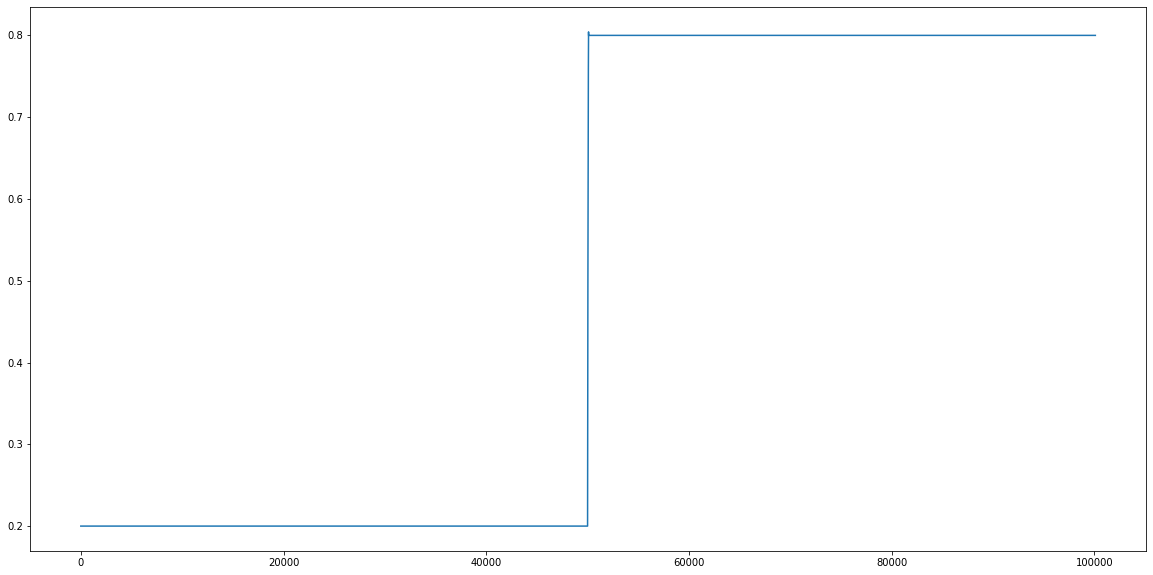

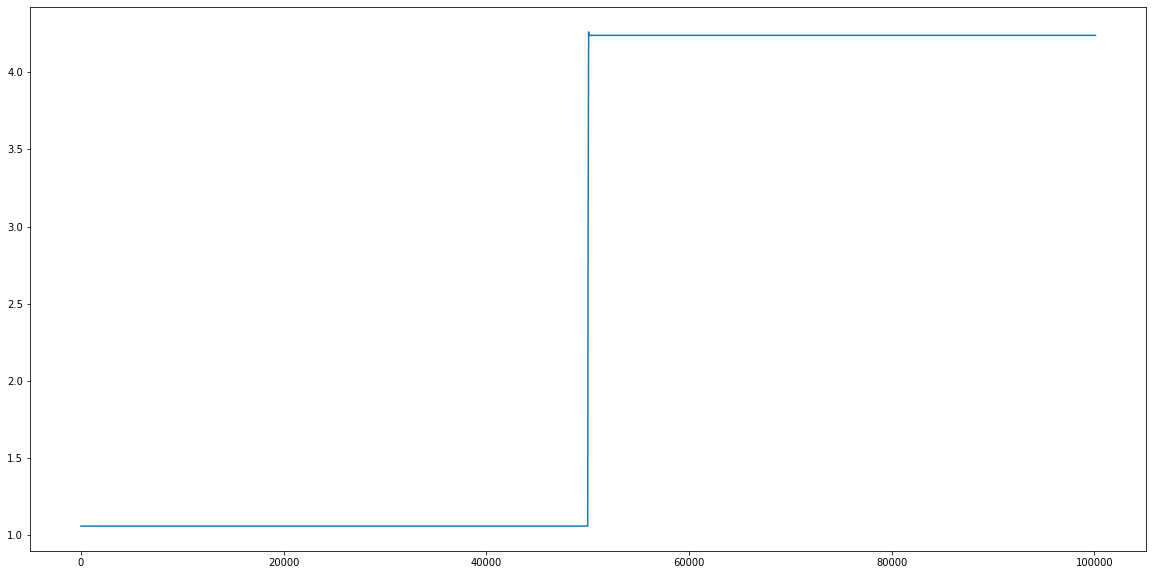

In [121]:
ns_seq_dict = get_non_stationary_sequence(initial_entropy = 0.2,final_entropy = 0.8)
entropy_seq = ns_seq_dict['entropy_seq']

plt.plot(entropy_seq/np.log(n_bins))
plt.show()
plt.plot(entropy_seq)
plt.show()

83600 0.5137818455696106


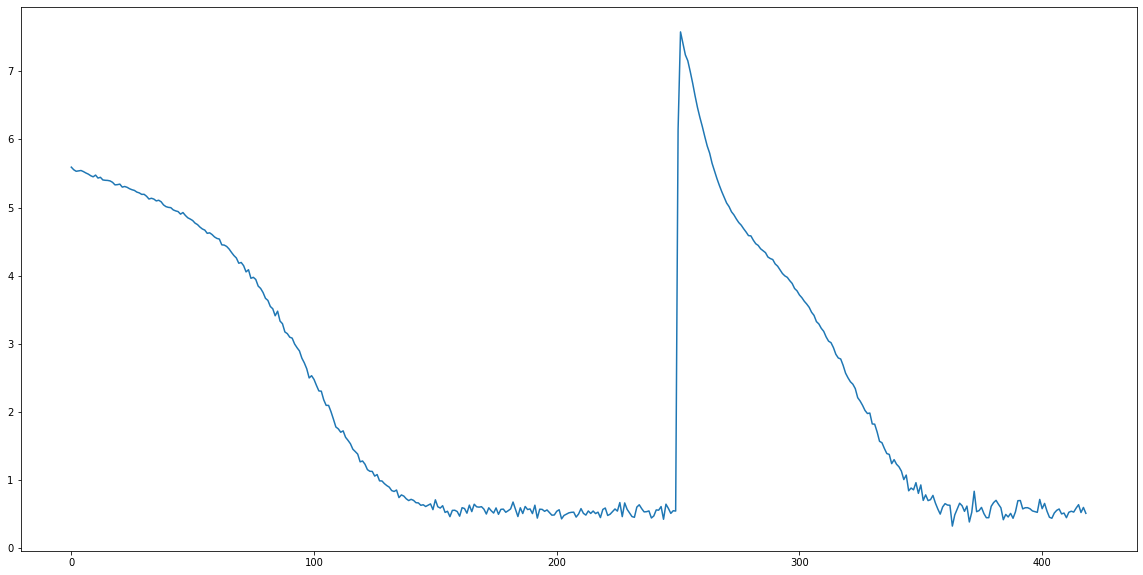

In [ ]:
for i in range(8):
  for j in range (8):

    n_exp = 10
    initial_entropy = (i+1)*0.1
    final_entropy = 0.1*(j+1)


    ind_file = 9
    forcing_train = True

    namefile = f"FeedForward_NSdistr_Nexp_{n_exp}_Temp_{config_dreaming['train']['temperature_dream']:.1f}_{ind_file}.pt"

    if os.path.isfile(namefile) is True and forcing_train is False:
        results = torch.load(namefile)
    else:
        results = dict()

        for k in range(n_exp):
            results[k] = dict()
            ns_seq_dict = get_non_stationary_sequence(initial_entropy = initial_entropy,final_entropy = final_entropy)
            train_loss_vanilla, distributions_vanilla, loss_past_information_vanilla = train_seq(ns_seq_dict, config_vanilla)
            train_loss_dreaming, distributions_dreaming, loss_past_information_dreaming = train_seq(ns_seq_dict, config_dreaming)
        
            results[k]['config_vanilla'] = config_vanilla
            results[k]['config_dreaming'] = config_dreaming
            results[k]['train_loss_vanilla'] = np.array(train_loss_vanilla)
            results[k]['train_loss_dreaming'] = np.array(train_loss_dreaming)
            results[k]['distributions_vanilla'] = distributions_vanilla
            results[k]['distributions_dreaming'] = distributions_dreaming
            results[k]['loss_past_information_vanilla'] = loss_past_information_vanilla
            results[k]['loss_past_information_dreaming'] = loss_past_information_dreaming
            results[k]['ns_seq_dict'] = ns_seq_dict

        torch.save(results, namefile)

    losses_vanilla = []
    distributions_vanilla = []
    losses_dreaming = []
    distributions_dreaming = []
    distrs_expected = []
    seq_expected = []

    for k in results.keys():
        losses_vanilla.append(results[k]['train_loss_vanilla'])
        losses_dreaming.append(results[k]['train_loss_dreaming']) 
        distributions_vanilla.append(results[k]['distributions_vanilla'])
        distributions_dreaming.append(results[k]['distributions_dreaming'])
        distrs_expected.append(results[k]['ns_seq_dict']['distrs_seq'])
        seq_expected.append(results[k]['ns_seq_dict']['seq'])

    losses_vanilla = np.array(losses_vanilla)
    distributions_vanilla = np.array(distributions_vanilla)
    losses_dreaming = np.array(losses_dreaming)
    distributions_dreaming = np.array(distributions_dreaming)
    distrs_expected = np.array(distrs_expected)
    
    xx = range(losses_vanilla.shape[1])
    mean_vanilla = losses_vanilla.mean(axis=0)
    mean_dreaming = losses_dreaming.mean(axis=0)
    
    subseqs_len = 50000
    transitions_len = 100
    middle = int((subseqs_len+transitions_len)/200)
    end = int((subseqs_len+transitions_len)/100)

    I_v = scipy.integrate.simps(mean_vanilla[middle:end]-entropy_seq[end*199], x=xx[middle:end], axis=0, even='avg')
    I_d = scipy.integrate.simps(mean_dreaming[middle:end]-entropy_seq[end*199], x=xx[middle:end], axis=0, even='avg')
    print(I_v,I_d)

    with open('/content/drive/My Drive/DreamingDistributions_2.txt', 'a') as f:
      f.write('\nEntropia Iniziale={:.2f}, entropia finale={:.3f},\
      n_bins={:.2f}, temperatura_dreaming={:.2f},\
      SoftMax={:.2f}, n_exp={:.2f},\
      Dreaming={:.2f}, Vanilla={:.2f}'.format(initial_entropy,final_entropy,
                                              n_bins,T,
                                              0.0,n_exp,I_d,I_v))

100000 3.368319034576416


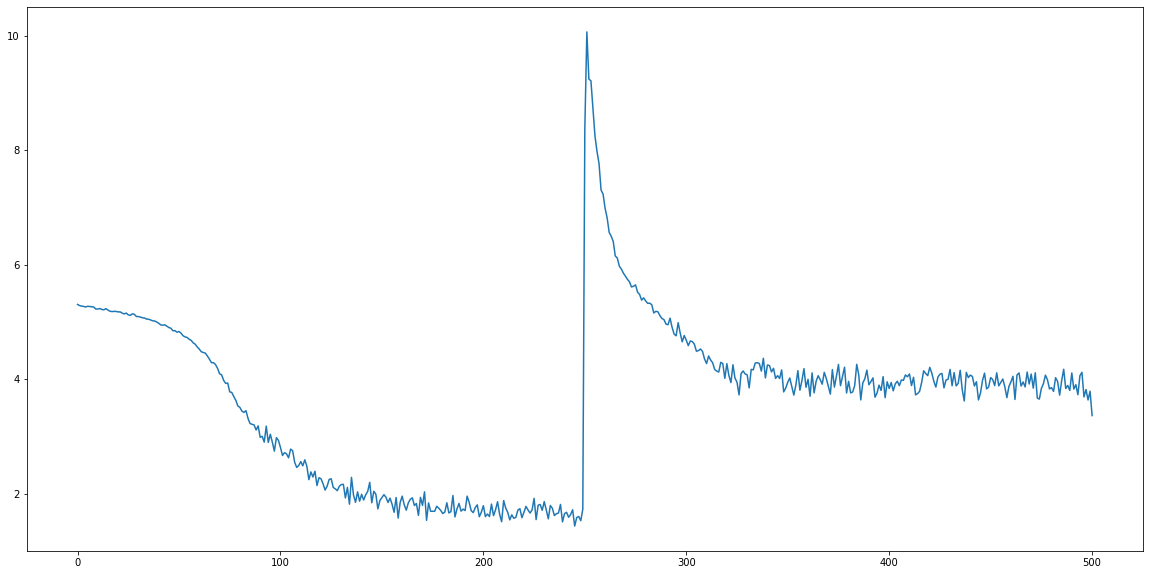

In [122]:
n_exp = 1
initial_entropy = 0.3
final_entropy = 0.7


ind_file = 9
forcing_train = True

namefile = f"FeedForward_NSdistr_Nexp_{n_exp}_Temp_{config_dreaming['train']['temperature_dream']:.1f}_{ind_file}.pt"

if os.path.isfile(namefile) is True and forcing_train is False:
    results = torch.load(namefile)
else:
    results = dict()

    for k in range(n_exp):
        results[k] = dict()
        ns_seq_dict = get_non_stationary_sequence(initial_entropy = initial_entropy,final_entropy = final_entropy)
        train_loss_vanilla, distributions_vanilla, loss_past_information_vanilla = train_seq(ns_seq_dict, config_vanilla)
        train_loss_dreaming, distributions_dreaming, loss_past_information_dreaming = train_seq(ns_seq_dict, config_dreaming)
    
        results[k]['config_vanilla'] = config_vanilla
        results[k]['config_dreaming'] = config_dreaming
        results[k]['train_loss_vanilla'] = np.array(train_loss_vanilla)
        results[k]['train_loss_dreaming'] = np.array(train_loss_dreaming)
        results[k]['distributions_vanilla'] = distributions_vanilla
        results[k]['distributions_dreaming'] = distributions_dreaming
        results[k]['loss_past_information_vanilla'] = loss_past_information_vanilla
        results[k]['loss_past_information_dreaming'] = loss_past_information_dreaming
        results[k]['ns_seq_dict'] = ns_seq_dict

    torch.save(results, namefile)


In [123]:
losses_vanilla = []
distributions_vanilla = []
losses_dreaming = []
distributions_dreaming = []
distrs_expected = []
seq_expected = []

for k in results.keys():
    losses_vanilla.append(results[k]['train_loss_vanilla'])
    losses_dreaming.append(results[k]['train_loss_dreaming']) 
    distributions_vanilla.append(results[k]['distributions_vanilla'])
    distributions_dreaming.append(results[k]['distributions_dreaming'])
    distrs_expected.append(results[k]['ns_seq_dict']['distrs_seq'])
    seq_expected.append(results[k]['ns_seq_dict']['seq'])

losses_vanilla = np.array(losses_vanilla)
distributions_vanilla = np.array(distributions_vanilla)
losses_dreaming = np.array(losses_dreaming)
distributions_dreaming = np.array(distributions_dreaming)
distrs_expected = np.array(distrs_expected)

In [124]:
#print(distrs_expected.shape)
#print(distributions_vanilla.shape)
#print(distributions_dreaming.shape)
#print(seq_expected[0][00000:30])
#print(seq_expected[1][00000:30])
#print(seq_expected[2][100000:100010])
#print(seq_expected[3][100000:100010])
#print(seq_expected[4][100000:100010])
#print(distrs_expected[0][0])
#print(distrs_expected[1][0])
#print(distrs_expected[0][100000])
#print(distrs_expected[1][100000])
#print(distance.euclidean(distributions_vanilla[0][100000],distrs_expected[0][100000]))

In [125]:
results[0].keys()

dict_keys(['config_vanilla', 'config_dreaming', 'train_loss_vanilla', 'train_loss_dreaming', 'distributions_vanilla', 'distributions_dreaming', 'loss_past_information_vanilla', 'loss_past_information_dreaming', 'ns_seq_dict'])

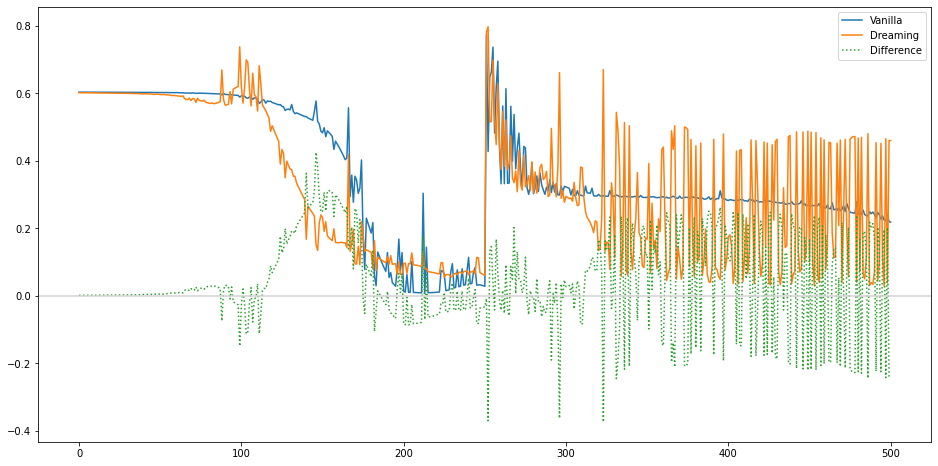

In [126]:
xx = range(losses_vanilla.shape[1])

mean_vanilla=[0]*len(distrs_expected[0])
vanilla = [0]*n_exp
for i in range(len(distrs_expected[0])-1):
 for k in range(n_exp):
  vanilla[k] = (distance.euclidean(distributions_vanilla[k][i],distrs_expected[k][i]))
  mean_vanilla[i]+=vanilla[k]/n_exp

if (n_exp>2):
 std_vanilla=[0]*len(distrs_expected[0])
 vanilla = [0]*n_exp
 for i in range(len(distrs_expected[0])-1):
  for k in range(n_exp):
   vanilla[k] = (distance.euclidean(distributions_vanilla[k][i],distrs_expected[k][i]))
   std_vanilla[i] += pow(pow(vanilla[k]-mean_vanilla[i],2)/n_exp,0.5)
else: 
 std_vanilla=[0]*len(distrs_expected[0])

mean_dreaming=[0]*len(distrs_expected[0])
dreaming = [0]*n_exp
for i in range(len(distrs_expected[0])-1):
 for k in range(n_exp):
  dreaming[k] = (distance.euclidean(distributions_dreaming[k][i],distrs_expected[k][i]))
  mean_dreaming[i]+=dreaming[k]/n_exp

if (n_exp>2):
 std_dreaming=[0]*len(distrs_expected[0])
 dreaming = [0]*n_exp
 for i in range(len(distrs_expected[0])-1):
  for k in range(n_exp):
   dreaming[k] = (distance.euclidean(distributions_dreaming[k][i],distrs_expected[k][i]))
   std_dreaming[i] += pow(pow(dreaming[k]-mean_dreaming[i],2)/n_exp,0.5)
else: 
 std_dreaming=[0]*len(distrs_expected[0])

magnitude=[0]*len(distrs_expected[0])
magn = [0]*n_exp
for i in range(len(distrs_expected[0])-1):
 for k in range(n_exp):
  magn[k] = (distance.euclidean(0,distrs_expected[k][i]))
  magnitude[i]+=magn[k]/n_exp

mean_vanilla = np.array(mean_vanilla)
std_vanilla = np.array(std_vanilla)
mean_dreaming = np.array(mean_dreaming)
std_dreaming = np.array(std_dreaming)



plt.figure(figsize=(16,8))
#plt.plot(xx, magnitude[::200], label='magnitude')
plt.fill_between(xx, mean_vanilla[::200]-std_vanilla[::200], mean_vanilla[::200]+std_vanilla[::200], alpha=0.4)
plt.plot(xx, mean_vanilla[::200], label='Vanilla')
plt.fill_between(xx, mean_dreaming[::200]-std_dreaming[::200], mean_dreaming[::200]+std_dreaming[::200], alpha=0.4)
plt.plot(xx, mean_dreaming[::200], label='Dreaming')
plt.plot(xx, mean_vanilla[::200] - mean_dreaming[::200], ':', label='Difference')

plt.axhline(0, color='lightgrey')
plt.legend(loc='best')
plt.show()

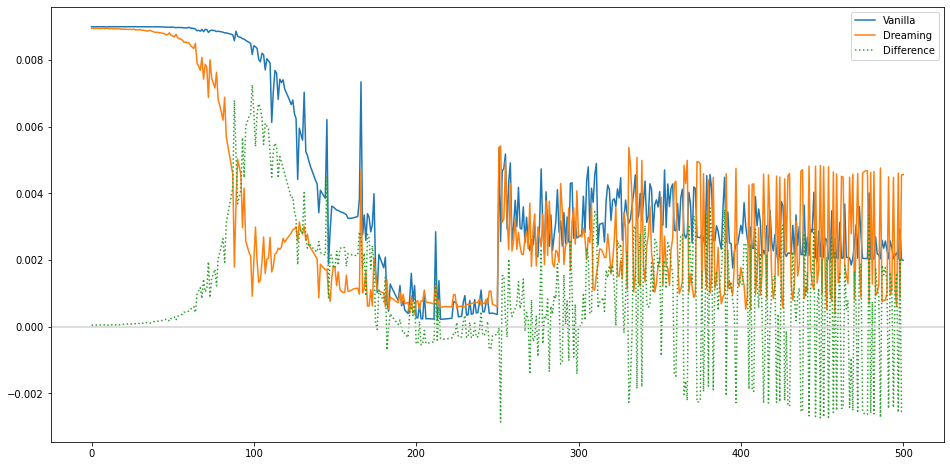

In [127]:
xx = range(losses_vanilla.shape[1])

mean_vanilla=[0]*len(distrs_expected[0])
vanilla = [0]*n_exp
for i in range(len(distrs_expected[0])-1):
 for k in range(n_exp):
  vanilla[k] = (emd(distributions_vanilla[k][i],distrs_expected[k][i]))
  mean_vanilla[i]+=vanilla[k]/n_exp

if (n_exp>2):
 std_vanilla=[0]*len(distrs_expected[0])
 vanilla = [0]*n_exp
 for i in range(len(distrs_expected[0])-1):
  for k in range(n_exp):
   vanilla[k] = (emd(distributions_vanilla[k][i],distrs_expected[k][i]))
   std_vanilla[i] += pow(pow(vanilla[k]-mean_vanilla[i],2)/n_exp,0.5)
else: 
 std_vanilla=[0]*len(distrs_expected[0])

mean_dreaming=[0]*len(distrs_expected[0])
dreaming = [0]*n_exp
for i in range(len(distrs_expected[0])-1):
 for k in range(n_exp):
  dreaming[k] = (emd(distributions_dreaming[k][i],distrs_expected[k][i]))
  mean_dreaming[i]+=dreaming[k]/n_exp

if (n_exp>2):
 std_dreaming=[0]*len(distrs_expected[0])
 dreaming = [0]*n_exp
 for i in range(len(distrs_expected[0])-1):
  for k in range(n_exp):
   dreaming[k] = (emd(distributions_dreaming[k][i],distrs_expected[k][i]))
   std_dreaming[i] += pow(pow(dreaming[k]-mean_dreaming[i],2)/n_exp,0.5)
else: 
 std_dreaming=[0]*len(distrs_expected[0])


mean_vanilla = np.array(mean_vanilla)
std_vanilla = np.array(std_vanilla)
mean_dreaming = np.array(mean_dreaming)
std_dreaming = np.array(std_dreaming)



plt.figure(figsize=(16,8))
#plt.plot(xx, magnitude[::200], label='magnitude')
plt.fill_between(xx, mean_vanilla[::200]-std_vanilla[::200], mean_vanilla[::200]+std_vanilla[::200], alpha=0.4)
plt.plot(xx, mean_vanilla[::200], label='Vanilla')
plt.fill_between(xx, mean_dreaming[::200]-std_dreaming[::200], mean_dreaming[::200]+std_dreaming[::200], alpha=0.4)
plt.plot(xx, mean_dreaming[::200], label='Dreaming')
plt.plot(xx, mean_vanilla[::200] - mean_dreaming[::200], ':', label='Difference')

plt.axhline(0, color='lightgrey')
plt.legend(loc='best')
plt.show()

250


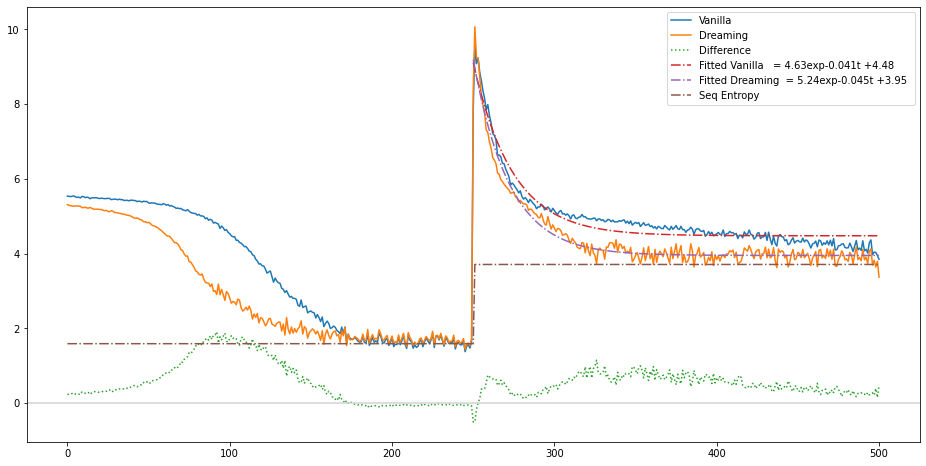

In [128]:
subseqs_len = 50000
transitions_len = 100

xx = range(losses_vanilla.shape[1])
mean_vanilla = losses_vanilla.mean(axis=0)
std_vanilla = losses_vanilla.std(axis=0)
mean_dreaming = losses_dreaming.mean(axis=0)
std_dreaming = losses_dreaming.std(axis=0)

entropy_seq = results[0]['ns_seq_dict']['entropy_seq']

plt.figure(figsize=(16,8))
plt.fill_between(xx, mean_vanilla-std_vanilla, mean_vanilla+std_vanilla, alpha=0.4)
plt.plot(xx, mean_vanilla, label='Vanilla')
plt.fill_between(xx, mean_dreaming-std_dreaming, mean_dreaming+std_dreaming, alpha=0.4)
plt.plot(xx, mean_dreaming, label='Dreaming')
plt.plot(xx, mean_vanilla - mean_dreaming, ':', label='Difference')


#Fit Esponenziale Vanilla
middle = int((subseqs_len+transitions_len)/200)
print(middle)
end = int((subseqs_len+transitions_len)/100)
popt, pcov = curve_fit(lambda t ,a , b, c: a * np.exp(b * t) + c, xx[0:middle+1], mean_vanilla[middle:end], p0=[3,-0.2,0.2], maxfev=50000)
a_v = popt[0]
b_v = popt[1]
c_v = popt[2]

x_fitted = np.linspace(xx[middle], np.max(xx), 100)
y_fitted = a_v* np.exp(b_v * (x_fitted-middle)) + c_v

plt.plot(x_fitted, y_fitted,'-.', label="Fitted Vanilla   = {:.2f}exp{:.3f}t +{:.2f} ".format(a_v,b_v,c_v))
#Fit Esponenziale Dreaming
popt, pcov = curve_fit(lambda t, a, b, c: a * np.exp(b * t) + c, xx[0:middle+1], mean_dreaming[middle:end], p0=[a_v,b_v,c_v], maxfev=50000)
a_d = popt[0]
b_d = popt[1]
c_d = popt[2]

x_fitted = np.linspace(xx[middle], np.max(xx), 100)
y_fitted = a_d * np.exp(b_d * (x_fitted-middle)) + c_d

plt.plot(x_fitted, y_fitted,'-.', label="Fitted Dreaming  = {:.2f}exp{:.3f}t +{:.2f} ".format(a_d,b_d,c_d))




plt.plot(entropy_seq[::seq_length], '-.', label='Seq Entropy')
plt.axhline(0, color='lightgrey')
plt.legend(loc='best')
plt.show()

250


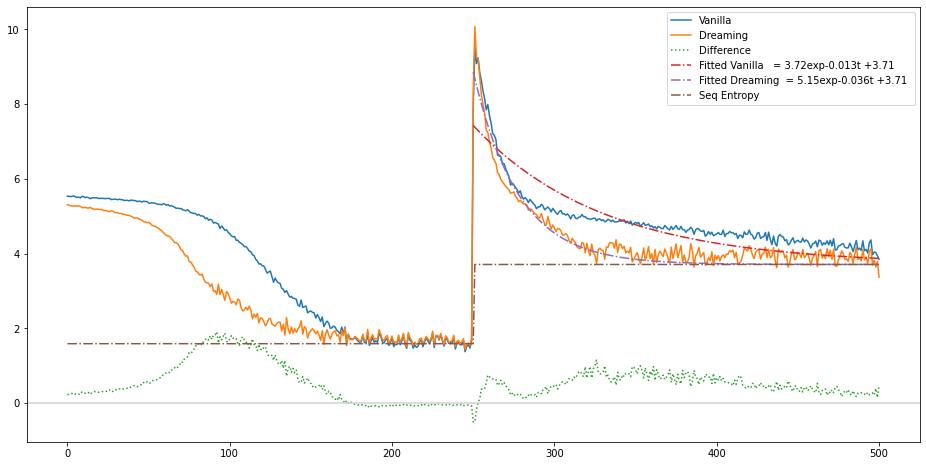

In [129]:
subseqs_len = 50000
transitions_len = 100

xx = range(losses_vanilla.shape[1])
c = losses_vanilla.mean(axis=0)
mean_vanilla = losses_vanilla.mean(axis=0)
std_vanilla = losses_vanilla.std(axis=0)
mean_dreaming = losses_dreaming.mean(axis=0)
std_dreaming = losses_dreaming.std(axis=0)

entropy_seq = results[0]['ns_seq_dict']['entropy_seq']

plt.figure(figsize=(16,8))
plt.fill_between(xx, mean_vanilla-std_vanilla, mean_vanilla+std_vanilla, alpha=0.4)
plt.plot(xx, mean_vanilla, label='Vanilla')
plt.fill_between(xx, mean_dreaming-std_dreaming, mean_dreaming+std_dreaming, alpha=0.4)
plt.plot(xx, mean_dreaming, label='Dreaming')
plt.plot(xx, mean_vanilla - mean_dreaming, ':', label='Difference')


#Fit Esponenziale Vanilla
middle = int((subseqs_len+transitions_len)/200)
print(middle)
end = int((subseqs_len+transitions_len)/100)
popt, pcov = curve_fit(lambda t ,a , b: a * np.exp(b * t) + entropy_seq[end*199], xx[0:middle+1], mean_vanilla[middle:end], p0=[3,-0.2], maxfev=50000)
a_v = popt[0]
b_v = popt[1]


x_fitted = np.linspace(xx[middle], np.max(xx), 100)
y_fitted = a_v* np.exp(b_v * (x_fitted-middle)) + entropy_seq[end*199]

plt.plot(x_fitted, y_fitted,'-.', label="Fitted Vanilla   = {:.2f}exp{:.3f}t +{:.2f} ".format(a_v,b_v,entropy_seq[end*199]))
#Fit Esponenziale Dreaming
popt, pcov = curve_fit(lambda t, a, b: a * np.exp(b * t) + entropy_seq[end*199], xx[0:middle+1], mean_dreaming[middle:end], p0=[a_v,b_v], maxfev=50000)
a_d = popt[0]
b_d = popt[1]

x_fitted = np.linspace(xx[middle], np.max(xx), 100)
y_fitted = a_d * np.exp(b_d * (x_fitted-middle)) + entropy_seq[end*199]

plt.plot(x_fitted, y_fitted,'-.', label="Fitted Dreaming  = {:.2f}exp{:.3f}t +{:.2f} ".format(a_d,b_d,entropy_seq[end*199]))




plt.plot(entropy_seq[::seq_length], '-.', label='Seq Entropy')
plt.axhline(0, color='lightgrey')
plt.legend(loc='best')
plt.show()

In [130]:
entropy_seq = results[0]['ns_seq_dict']['entropy_seq']
entropy_seq[end*199]

3.708835989240651

In [131]:
#from scipy.integrate import quad
#def integrand(x, a, b):
#    return a * np.exp(b * x)
#I_v = quad(integrand, 0, 250, args=(a_v,b_v))
#I_d = quad(integrand, 0, 250, args=(a_d,b_d))

#print(I_v[0])
#print(I_d[0])

In [132]:
I_v = scipy.integrate.simps(mean_vanilla[middle:end]-entropy_seq[end*199], x=xx[middle:end], axis=0, even='avg')
I_d = scipy.integrate.simps(mean_dreaming[middle:end]-entropy_seq[end*199], x=xx[middle:end], axis=0, even='avg')
print(I_v,I_d)

305.1856165916113 176.60844065650193


In [134]:
with open('/content/drive/My Drive/DreamingDistributions_1.txt', 'a') as f:
  f.write('\nEntropia Iniziale={:.2f}, entropia finale={:.3f},\
  n_bins={:.2f}, temperatura_dreaming={:.2f},\
  SoftMax={:.2f}, n_exp={:.2f},\
  Dreaming={:.2f}, Vanilla={:.2f}'.format(initial_entropy,final_entropy,
                                          n_bins,T,
                                          0.0,n_exp,I_d,I_v))



In [135]:
# opening the file in read mode
my_file = open("/content/drive/My Drive/DreamingDistributions_1_simpliefied.txt", "r")
  
# reading the file
data = my_file.read()
# replacing end of line('/n') with ' ' and

# splitting the text it further when '.' is seen.
data_into_list = data.replace('\n', ' ').split(",")

newarray = [0]*(len(data_into_list))
data_into_list= np.array(data_into_list)

for i in range(len(data_into_list)):
 newarray[i]  = float(data_into_list[i])
a = int(len(data_into_list)/4)
newarray = np.reshape(newarray, (a, 4))
my_file.close()

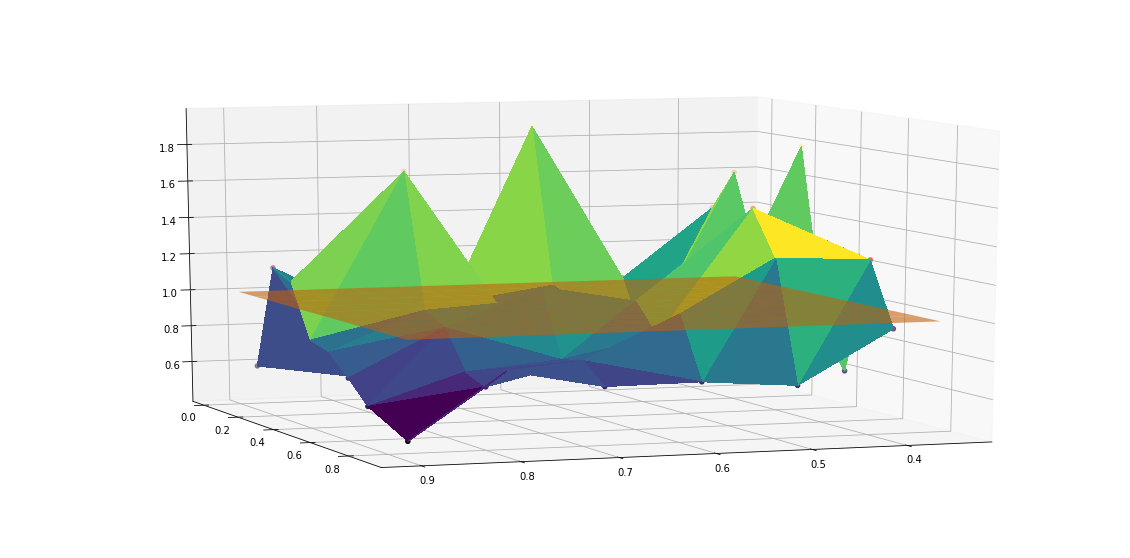

<Figure size 1152x576 with 0 Axes>

In [143]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
from matplotlib.pyplot import figure as fig

plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# Make data
X = np.array([0.0]*a)
Y = np.array([0.0]*a)
Z = np.array([0.0]*a)
for i in range(a):
 X[i] = newarray[i,0]
 Y[i] = newarray[i,1]
 Z[i] = newarray[i,3]/newarray[i,2]
plt.figure(figsize=(16,8))
ax.scatter3D(X, Y, Z, c=Z, cmap='magma');
surf = ax.plot_trisurf(X, Y, Z, linewidth=0,cmap=cm.viridis, antialiased=False)

x = np.linspace(0.35, 0.9, 10)
y = np.linspace(0, 0.9, 10)

x, y = np.meshgrid(x, y)
eq = 0. * x + 0.0 * y + 1.0



ax = fig.gca(projection='3d')

ax.plot_surface(x, y, eq,alpha=.6)




ax.view_init(10, 70,)

plt.show()

In [137]:

(newarray[i,3]-newarray[i,2]).sum()

-43.47